In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
import sklearn
import PIL
import torch
import torchvision
from matplotlib import cm

import warnings
warnings.filterwarnings('ignore')

### Зачем
- Посмотрим, как проводится операция свертки;
- Посмотрим, как работает pooling;
- Попробуем собрать сверточную нейронную сеть на PyTorch

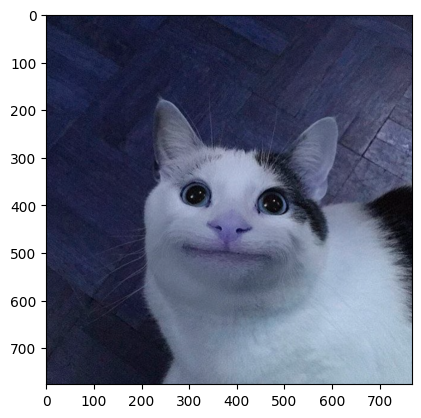

In [2]:
image = cv2.imread('./image.png')
plt.imshow(image);

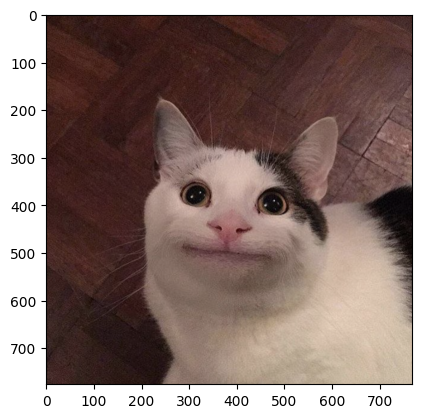

In [3]:
image_ex = image[...,::-1]
plt.imshow(image_ex)

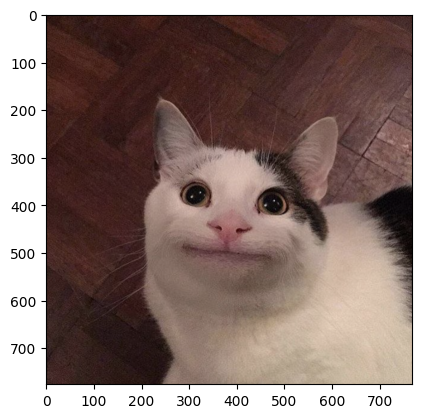

In [4]:
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb);

Посмотрим на каналы изображения отдельно

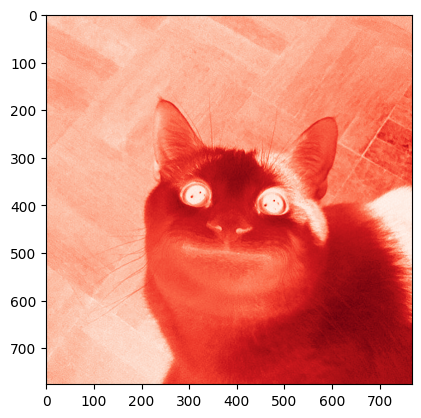

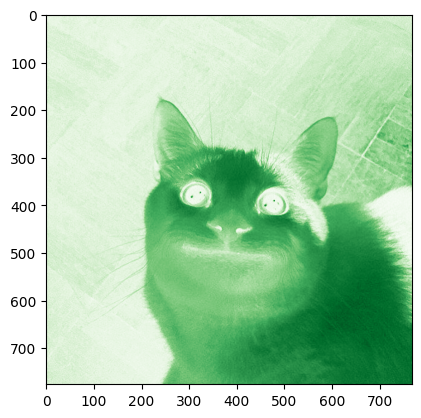

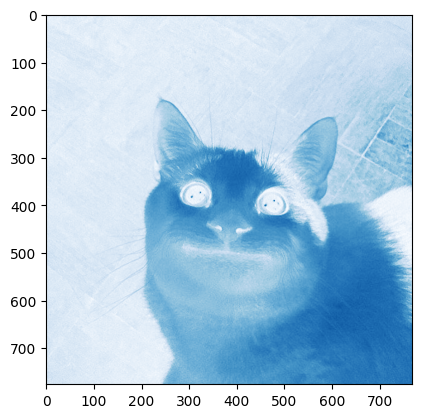

In [7]:
img_mat = np.array(image_rgb)
plt.imshow(img_mat[:, :, 0], cmap=cm.Reds)
plt.show()

img_mat = np.array(image_rgb)
plt.imshow(img_mat[:, :, 1], cmap=cm.Greens)
plt.show()

img_mat = np.array(image_rgb)
plt.imshow(img_mat[:, :, 2], cmap=cm.Blues)
plt.show()

# Операция свертки

- Количество входных каналов `in_channels`
- Количество выходных каналов `out_channels`
- Размер ядра `kernel_size`
- Шаг `stride`
- Паддинг `padding`
- Режим паддинга `padding_mode` (`'zeros'`, `'reflect'`, ...)


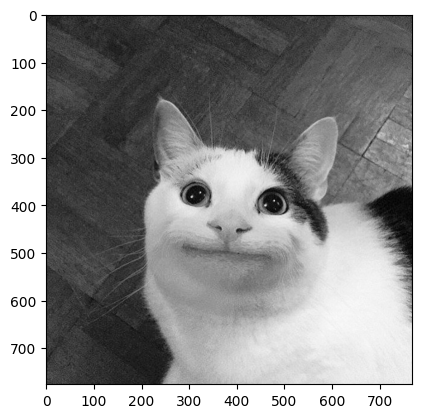

In [8]:
bw_image = cv2.imread('./image.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(bw_image, cmap=plt.cm.Greys_r)

In [7]:
# !pip3 install scipy

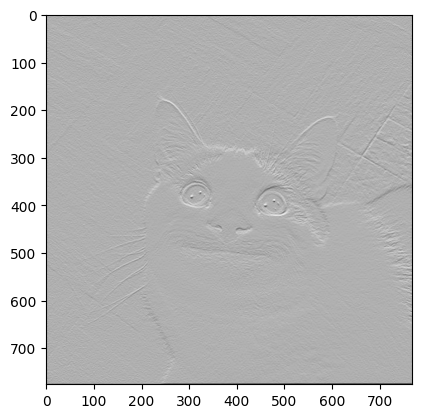

In [10]:
from scipy.signal import convolve2d

G_y = np.array([
    [1, 2, 1],
    [0, 0, 0],
    [-1, -2, -1]
])

res_y = convolve2d(bw_image, G_y, "same")
plt.imshow(res_y, cmap=plt.cm.Greys_r)

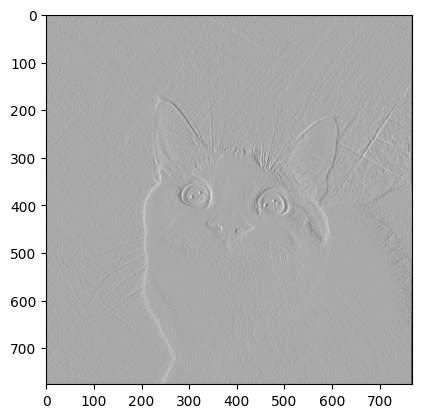

In [11]:
G_x = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
])

res_x = convolve2d(bw_image, G_y.T, "same")
plt.imshow(res_x, cmap=plt.cm.Greys_r)

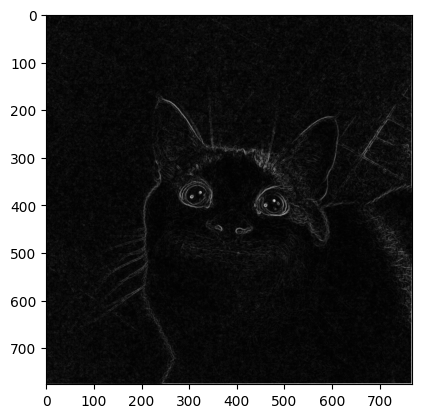

In [12]:
res_sobel = (res_x**2 + res_y**2)**0.5
plt.imshow(res_sobel, cmap=plt.cm.Greys_r)

# Пулинг

In [13]:
import numpy as np

conv_output = np.array([
    [10, 12,  8,  7],
    [ 4, 11,  5,  9],
    [18, 13,  7,  7],
    [ 3, 15,  2,  2]
])
conv_output

array([[10, 12,  8,  7],
       [ 4, 11,  5,  9],
       [18, 13,  7,  7],
       [ 3, 15,  2,  2]])

Сначала попробуем со `stride=2`

In [14]:
pool_size = 2
stride = 2

def get_pools(img=conv_output, pool_size=2, stride=2):

    pools = []
    for i in np.arange(conv_output.shape[0], step=stride):
        for j in np.arange(conv_output.shape[0], step=stride):
            mat = conv_output[i:i+pool_size, j:j+pool_size]
            pools.append(mat)
    pools = np.array(pools)
    return pools

pools = get_pools()
pools

array([[[10, 12],
        [ 4, 11]],

       [[ 8,  7],
        [ 5,  9]],

       [[18, 13],
        [ 3, 15]],

       [[ 7,  7],
        [ 2,  2]]])

In [16]:
def max_pooling(pools: np.array) -> np.array:

    num_pools = pools.shape[0]

    # Размер матрицы после пулинга
    tgt_shape = (int(np.sqrt(num_pools)), int(np.sqrt(num_pools)))

    # Здесь будем хранить максимумы с каждого из пулов
    pooled = []
    for pool in pools:
        pooled.append(np.max(pool))

    return np.array(pooled).reshape(tgt_shape)

In [17]:
max_pooling(pools=pools)

array([[12,  9],
       [18,  7]])

# Сверточная нейронная сеть

In [3]:
import torch
import torch.nn.functional as F
import torchvision
import os
from torch import nn
from tqdm import tqdm

In [4]:
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ]
)

In [5]:
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


In [6]:
seed_everything(42)

mnist_train = torchvision.datasets.MNIST(
    './mnist/',
    train=True,
    download=True,
    transform=transform
)

mnist_val = torchvision.datasets.MNIST(
    './mnist/',
    train=False,
    download=True,
    transform=transform
)

train_dataloader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(mnist_val, batch_size=64, shuffle=True)

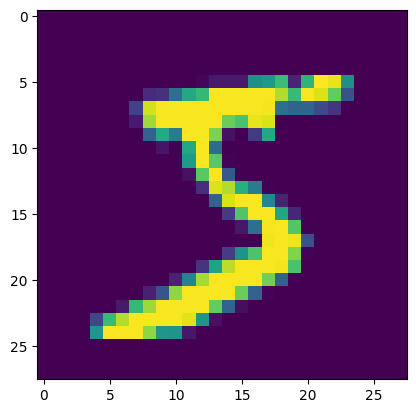

In [7]:
plt.imshow(mnist_train[0][0].squeeze(0).numpy().reshape([28, 28]))

In [23]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [24]:
def train(model, optimizer, n_epochs=5):
    for epoch in range(n_epochs):

        # обучение
        for x_train, y_train in tqdm(train_dataloader):
            y_pred = model(x_train)
            loss = F.cross_entropy(y_pred, y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # валидация
        if epoch % 2 == 0:
            val_loss = []
            val_accuracy = []
            with torch.no_grad():
                for x_val, y_val in tqdm(val_dataloader):
                    y_pred = model(x_val)
                    loss = F.cross_entropy(y_pred, y_val)
                    val_loss.append(loss.numpy())
                    val_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist())

            print(f'Epoch: {epoch}, loss: {np.mean(val_loss)}, accuracy: {np.mean(val_accuracy)}')

In [25]:
train(model, optimizer)

100%|██████████| 157/157 [00:01<00:00, 97.02it/s]


Epoch: 0, loss: 0.3202982246875763, accuracy: 0.9098


100%|██████████| 157/157 [00:01<00:00, 100.08it/s]


Epoch: 2, loss: 0.23290136456489563, accuracy: 0.9315


100%|██████████| 157/157 [00:01<00:00, 101.23it/s]

Epoch: 4, loss: 0.1869591921567917, accuracy: 0.9461


In [26]:
0.9461

0.9461

In [27]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5),  # grayscale
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),   # сократим изображение в 4 раза по каждой из сторон
    nn.Flatten(),
    nn.Linear(6*6*10, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [28]:
train(model, optimizer)

100%|██████████| 157/157 [00:01<00:00, 90.61it/s]


Epoch: 0, loss: 0.26601430773735046, accuracy: 0.9249


100%|██████████| 157/157 [00:03<00:00, 51.74it/s]


Epoch: 2, loss: 0.1271723061800003, accuracy: 0.9627


100%|██████████| 157/157 [00:01<00:00, 91.66it/s]

Epoch: 4, loss: 0.08589120209217072, accuracy: 0.9745


In [27]:
0.9747

0.9747

# Домашнее задание

Обучите сверточную нейронную сеть на датасете MNIST, взяв любой другой оптимизатор (кроме SGD) и любую другую функцию ошибки (кроме cross-entropy loss). Попробуйте поварьировать параметры: кол-во ядер, `kernel_size` и побить текущий бейзлайн в `0.9747`. Выведите количество обучаемых параметров.    
Какого качества удалось достичь? Попробуйте залоггировать Ваши результаты - построить графики того, как менялись метрики качества (accuracy, loss) с течением эпох, включить логгирование, сравнить результаты между собой при разных параметрах.

Любые дополнительные улучшения (как по методам, так и по коду пайплайна) приветствуются!

*Цель:* выработать навык обучения нейронных сетей (в частности сверточных) на основе средств PyTorch, начиная от загрузки датасетами и заканчивая выводами результатов, их логгированием, сравнением и анализом.

In [42]:
model = nn.Sequential(
    nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
    nn.MaxPool2d(2),                # 28->14
    nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
    nn.MaxPool2d(2),                # 14->7
    nn.Flatten(),
    nn.Linear(64*7*7, 128), nn.ReLU(),
    nn.Linear(128, 10),
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def train2(model, optimizer, n_epochs=5):
    for epoch in range(n_epochs):

        # обучение
        for x_train, y_train in tqdm(train_dataloader):
            y_pred = model(x_train)
            loss = F.cross_entropy(y_pred, y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # валидация
        if epoch % 2 == 0:
            val_loss = []
            val_accuracy = []
            with torch.no_grad():
                for x_val, y_val in tqdm(val_dataloader):
                    y_pred = model(x_val)
                    loss = F.cross_entropy(y_pred, y_val)
                    val_loss.append(loss.numpy())
                    val_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist())
            

            print(f'Epoch: {epoch}, loss: {np.mean(val_loss)}, accuracy: {np.mean(val_accuracy)}')

In [48]:
train2(model, optimizer)

100%|██████████| 157/157 [00:02<00:00, 60.02it/s]


Epoch: 0, loss: 0.039952635765075684, accuracy: 0.9871


100%|██████████| 157/157 [00:02<00:00, 59.87it/s]


Epoch: 2, loss: 0.033826135098934174, accuracy: 0.9882


100%|██████████| 157/157 [00:02<00:00, 59.75it/s]

Epoch: 4, loss: 0.02963409386575222, accuracy: 0.9906


In [9]:
model = nn.Sequential(
    nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
    nn.MaxPool2d(2),                # 28->14
    nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
    nn.MaxPool2d(2),                # 14->7
    nn.Flatten(),
    nn.Linear(64*7*7, 128), nn.ReLU(),
    nn.Linear(128, 10),
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [8]:
def train3(model, optimizer, n_epochs=5):
    for epoch in range(n_epochs):

        # обучение
        for x_train, y_train in tqdm(train_dataloader):
            y_pred = model(x_train)
            log_probs = F.log_softmax(y_pred, dim=1)
            loss = F.nll_loss(log_probs, y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # валидация
        if epoch % 2 == 0:
            val_loss = []
            val_accuracy = []
            with torch.no_grad():
                for x_val, y_val in tqdm(val_dataloader):
                    y_pred = model(x_val)
                    log_probs = F.log_softmax(y_pred, dim=1)
                    loss = F.nll_loss(log_probs, y_val)
                    val_loss.append(loss.numpy())
                    val_accuracy.extend((torch.argmax(log_probs, dim=-1) == y_val).numpy().tolist())


            print(f'Epoch: {epoch}, loss: {np.mean(val_loss)}, accuracy: {np.mean(val_accuracy)}')

In [10]:
train3(model, optimizer)

100%|██████████| 157/157 [00:03<00:00, 49.99it/s]


Epoch: 0, loss: 0.04606321081519127, accuracy: 0.9845


100%|██████████| 157/157 [00:02<00:00, 61.12it/s]


Epoch: 2, loss: 0.02968091145157814, accuracy: 0.9895


100%|██████████| 157/157 [00:02<00:00, 61.39it/s]

Epoch: 4, loss: 0.03086533583700657, accuracy: 0.9906


In [11]:
model = nn.Sequential(
    nn.Conv2d(1, 32, 3, stride=2, padding=1), nn.ReLU(),
    nn.Conv2d(32, 64, 3, stride=2, padding=1), nn.ReLU(), 
    nn.Flatten(),
    nn.Linear(64*7*7, 128), nn.ReLU(),
    nn.Linear(128, 10),
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [12]:
def train4(model, optimizer, n_epochs=5):
    for epoch in range(n_epochs):

        # обучение
        for x_train, y_train in tqdm(train_dataloader):
            y_pred = model(x_train)
            log_probs = F.log_softmax(y_pred, dim=1)
            loss = F.nll_loss(log_probs, y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # валидация
        if epoch % 2 == 0:
            val_loss = []
            val_accuracy = []
            with torch.no_grad():
                for x_val, y_val in tqdm(val_dataloader):
                    y_pred = model(x_val)
                    log_probs = F.log_softmax(y_pred, dim=1)
                    loss = F.nll_loss(log_probs, y_val)
                    val_loss.append(loss.numpy())
                    val_accuracy.extend((torch.argmax(log_probs, dim=-1) == y_val).numpy().tolist())


            print(f'Epoch: {epoch}, loss: {np.mean(val_loss)}, accuracy: {np.mean(val_accuracy)}')

In [13]:
train4(model, optimizer)

100%|██████████| 157/157 [00:01<00:00, 86.91it/s]


Epoch: 0, loss: 0.059494007378816605, accuracy: 0.9809


100%|██████████| 157/157 [00:01<00:00, 87.66it/s]


Epoch: 2, loss: 0.047813933342695236, accuracy: 0.9841


100%|██████████| 157/157 [00:01<00:00, 81.67it/s]

Epoch: 4, loss: 0.04525420814752579, accuracy: 0.9869


In [14]:
model = nn.Sequential(
    nn.Conv2d(1, 32, 3, stride=2, padding=1), nn.ReLU(),
    nn.Conv2d(32, 64, 3, stride=2, padding=1), nn.ReLU(), 
    nn.Flatten(),
    nn.Linear(64*7*7, 128), nn.ReLU(),
    nn.Linear(128, 10),
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [16]:
def train5(model, optimizer, n_epochs=5):
    for epoch in range(n_epochs):

        # обучение
        for x_train, y_train in tqdm(train_dataloader):
            y_pred = model(x_train)
            loss = F.cross_entropy(y_pred, y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # валидация
        if epoch % 2 == 0:
            val_loss = []
            val_accuracy = []
            with torch.no_grad():
                for x_val, y_val in tqdm(val_dataloader):
                    y_pred = model(x_val)
                    loss = F.cross_entropy(y_pred, y_val)
                    val_loss.append(loss.numpy())
                    val_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist())



            print(f'Epoch: {epoch}, loss: {np.mean(val_loss)}, accuracy: {np.mean(val_accuracy)}')

In [17]:
train5(model, optimizer)

100%|██████████| 157/157 [00:01<00:00, 88.15it/s]


Epoch: 0, loss: 0.06181822717189789, accuracy: 0.9799


100%|██████████| 157/157 [00:01<00:00, 88.95it/s]


Epoch: 2, loss: 0.04059796407818794, accuracy: 0.9878


100%|██████████| 157/157 [00:01<00:00, 88.34it/s]

Epoch: 4, loss: 0.03849814832210541, accuracy: 0.989


Выводы: Я думаю чем больше maxpool2d тем сильнее режется картинка. Возможно теряются какието тонкости и детали. Думаю 2 самый лучший параметр. Поэтому и заметно, что точность модельки очень хорошая. Адам очень хорошо. Видно, что он сразу уделывает СГД. Видно что на ранних эпохах Адам сразу выходит на хорошее качество гдето ~0.96-0.97, в отличие от SGD где у него было ~0.92. Попробовал NLLLoss вместо Cross Entropy и  впринципе результат почти одинаковый.